# Importing the libraries

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [283]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [196]:
!pip install memory-profiler

In [197]:
from memory_profiler import memory_usage

In [198]:
import time

# Knowledge Distillation for European dataset

## Importing the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
eu_data = pd.read_excel("drive/MyDrive/datasets_ont_lab/DataSet_EU_3k_5k.xlsx")

## Data preprocessing

We will be using `channel 24`.

In [136]:
channel_24_columns = ['Power_24', 'NLI_24', 'ASE_24', 'frequency_24', 'Total Distance(m)', 'No. Spans', 'GSNR_24']
data_eu = eu_data[channel_24_columns]

Display the first few rows of the dataset

In [137]:
data_eu.head()

,Power_24,NLI_24,ASE_24,frequency_24,Total Distance(m),No. Spans,GSNR_24
0,0.000007,4.842871e-08,4.864403e-08,192450000000000,690608.0,8,76.723141
1,0.000007,3.885630e-08,5.247437e-08,192450000000000,690608.0,8,79.514276
2,0.000000,0.000000e+00,7.411925e-06,192450000000000,690608.0,8,0.000000
3,0.000000,0.000000e+00,7.423609e-06,192450000000000,690608.0,8,0.000000
4,0.000000,0.000000e+00,7.187909e-06,192450000000000,690608.0,8,0.000000


Checking data types of columns

In [138]:
data_eu.dtypes

Power_24             float64
NLI_24               float64
ASE_24               float64
frequency_24           int64
Total Distance(m)    float64
No. Spans              int64
GSNR_24              float64
dtype: object

Summary statistics

In [139]:
data_eu.describe()

,Power_24,NLI_24,ASE_24,frequency_24,Total Distance(m),No. Spans,GSNR_24
count,18000.000000,1.800000e+04,1.800000e+04,1.800000e+04,1.800000e+04,18000.00000,18000.000000
mean,0.000024,6.083256e-07,3.177172e-05,1.924500e+14,1.970755e+06,22.00000,15.672157
std,0.000038,1.071328e-06,4.231358e-05,0.000000e+00,1.023753e+06,11.41668,23.902547
min,0.000000,0.000000e+00,3.796777e-08,1.924500e+14,6.692970e+05,7.00000,0.000000
25%,0.000000,0.000000e+00,3.249564e-06,1.924500e+14,6.906080e+05,8.00000,0.000000
50%,0.000000,0.000000e+00,7.406459e-06,1.924500e+14,2.167932e+06,24.50000,0.000000
75%,0.000019,3.221394e-07,1.000000e-04,1.924500e+14,3.051078e+06,34.00000,17.120952
max,0.000095,3.670818e-06,1.000000e-04,1.924500e+14,3.077685e+06,34.00000,91.353745


Check for missing values

In [140]:
data_eu.isnull().sum()

Power_24             0
NLI_24               0
ASE_24               0
frequency_24         0
Total Distance(m)    0
No. Spans            0
GSNR_24              0
dtype: int64

## Splitting dataset into training set and validation set

In [141]:
X = data_eu.iloc[:, :-1].values
y = data_eu.iloc[:, -1].values

In [142]:
print(f'X size = {X.shape}\ny size = {y.shape}')

X size = (18000, 6)
y size = (18000,)


In [143]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")

Training set shape: (14400, 6), (14400,)
Validation set shape: (3600, 6), (3600,)


## Applying feature scaling

In [145]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)

In [146]:
print(f'X_train[0] = {X_train[0]}\nX_train_scaled[0] = {X_train_scaled[0]}')

X_train[0] = [7.33494511e-06 5.39951760e-08 4.64896996e-08 1.92450000e+14
 6.90608000e+05 8.00000000e+00]
X_train_scaled[0] = [-0.43357926 -0.51600236 -0.74863056  0.         -1.24578461 -1.22149915]


In [147]:
print(f'X_val[0] = {X_val[0]}\nX_val_scaled[0] = {X_val_scaled[0]}')

X_val[0] = [7.46224015e-06 4.62333751e-08 5.36407667e-08 1.92450000e+14
 6.90608000e+05 8.00000000e+00]
X_val_scaled[0] = [-0.43023209 -0.5232592  -0.74846147  0.         -1.24578461 -1.22149915]


## Building and training teacher model

In [95]:
# Define the model architecture
teacher_model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', name='hidden_layer_1'),
    Dense(64, activation='relu', name='hidden_layer_2'),
    Dense(32, activation='relu', name='hidden_layer_3'),
    Dense(1, activation='linear', name='output_layer')
])

In [96]:
# Compile the model
teacher_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [97]:
# Train the model
history_teacher_model = teacher_model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val), batch_size=32)

Epoch 1/50
450/450 [==============================] - 3s 5ms/step - loss: 221.0057 - mae: 7.5323 - val_loss: 16.3473 - val_mae: 2.0522
Epoch 2/50
450/450 [==============================] - 2s 4ms/step - loss: 14.9915 - mae: 1.9320 - val_loss: 11.8094 - val_mae: 1.6078
Epoch 3/50
450/450 [==============================] - 1s 2ms/step - loss: 10.4576 - mae: 1.5707 - val_loss: 7.8693 - val_mae: 1.3481
Epoch 4/50
450/450 [==============================] - 1s 3ms/step - loss: 6.9396 - mae: 1.2948 - val_loss: 5.4056 - val_mae: 1.1379
Epoch 5/50
450/450 [==============================] - 1s 2ms/step - loss: 4.6439 - mae: 1.0571 - val_loss: 3.9100 - val_mae: 0.9582
Epoch 6/50
450/450 [==============================] - 1s 2ms/step - loss: 4.0189 - mae: 0.9324 - val_loss: 3.6615 - val_mae: 0.8704
Epoch 7/50
450/450 [==============================] - 1s 3ms/step - loss: 4.0875 - mae: 0.8845 - val_loss: 4.0153 - val_mae: 0.7918
Epoch 8/50
450/450 [==============================] - 1s 3ms/step - lo

In [98]:
# Evaluate the model on the validation set
val_loss, val_mae = teacher_model.evaluate(X_val_scaled, y_val)
print(f'Validation Loss: {val_loss:.3f}')
print(f'Validation MAE: {val_mae:.3f}')

113/113 [==============================] - 0s 2ms/step - loss: 2.4011 - mae: 0.5838
Validation Loss: 2.401
Validation MAE: 0.584


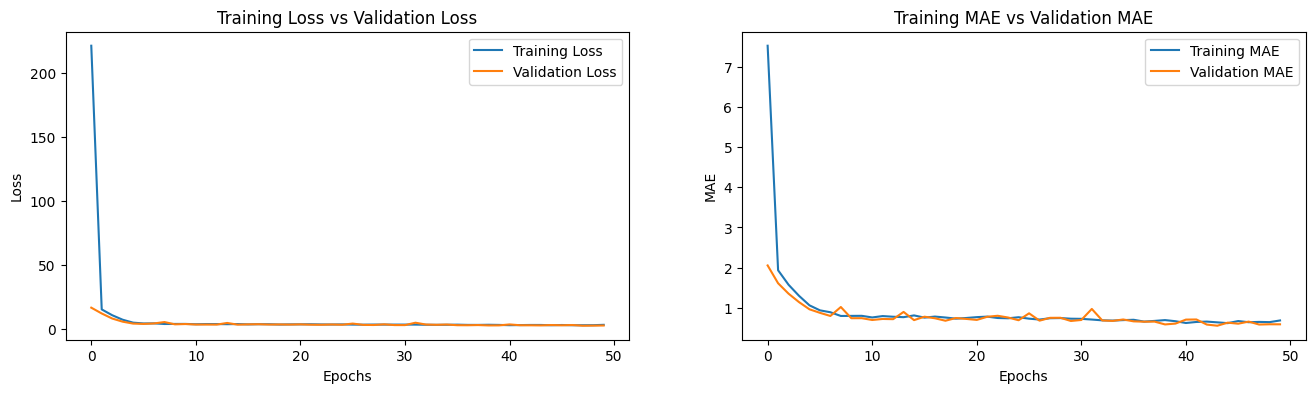

In [167]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_teacher_model.history['loss'], label='Training Loss')
plt.plot(history_teacher_model.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_teacher_model.history['mae'], label='Training MAE')
plt.plot(history_teacher_model.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

## Knowledge Distillation - Hard

In [99]:
# Define the student model architecture
student_model_1 = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu', name='hidden_layer_1'),
    Dense(32, activation='relu', name='hidden_layer_2'),
    Dense(1, activation='linear', name='output_layer')
])

In [100]:
# Compile the student model
student_model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [101]:
# Train the student model
history_student_model_hard = student_model_1.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val), batch_size=32)

Epoch 1/50
450/450 [==============================] - 2s 3ms/step - loss: 414.5309 - mae: 12.3110 - val_loss: 210.3161 - val_mae: 8.9641
Epoch 2/50
450/450 [==============================] - 2s 4ms/step - loss: 99.7739 - mae: 6.3089 - val_loss: 30.9052 - val_mae: 3.5560
Epoch 3/50
450/450 [==============================] - 2s 4ms/step - loss: 21.2133 - mae: 2.7769 - val_loss: 15.9591 - val_mae: 2.3304
Epoch 4/50
450/450 [==============================] - 4s 8ms/step - loss: 15.0783 - mae: 2.1298 - val_loss: 12.8178 - val_mae: 1.8559
Epoch 5/50
450/450 [==============================] - 2s 5ms/step - loss: 12.3069 - mae: 1.7406 - val_loss: 10.7117 - val_mae: 1.5706
Epoch 6/50
450/450 [==============================] - 2s 4ms/step - loss: 10.6524 - mae: 1.5936 - val_loss: 9.6355 - val_mae: 1.4890
Epoch 7/50
450/450 [==============================] - 2s 4ms/step - loss: 9.3548 - mae: 1.5150 - val_loss: 8.2829 - val_mae: 1.3856
Epoch 8/50
450/450 [==============================] - 2s 5ms/s

In [102]:
# Evaluate the student model on the validation set
student_val_loss, student_val_mae = student_model_1.evaluate(X_val_scaled, y_val)
print(f'Student Model Validation Loss: {student_val_loss:.3f}')
print(f'Student Model Validation MAE: {student_val_mae:.3f}')

113/113 [==============================] - 0s 2ms/step - loss: 2.9285 - mae: 0.6879
Student Model Validation Loss: 2.928
Student Model Validation MAE: 0.688


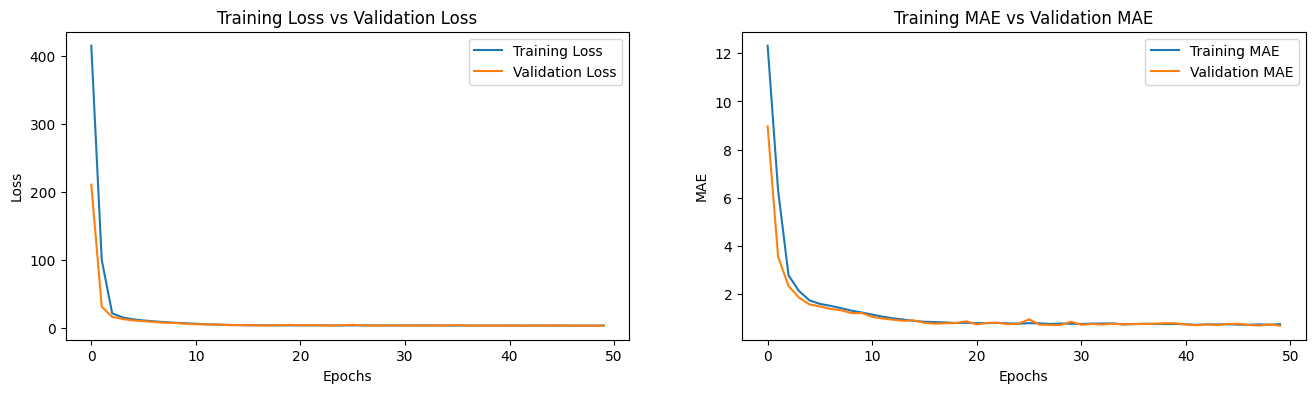

In [169]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_student_model_hard.history['loss'], label='Training Loss')
plt.plot(history_student_model_hard.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_student_model_hard.history['mae'], label='Training MAE')
plt.plot(history_student_model_hard.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

## Knowledge Distillation - Soft

In [180]:
# Function to get softened outputs
def get_softened_outputs(model, data, temperature):
    logits = model.predict(data) / temperature
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

### temperature = 1

In [181]:
# Get softened outputs from the teacher model
temperature = 1
soft_targets = get_softened_outputs(teacher_model, X_train_scaled, temperature)

# Check for invalid values in soft targets
print(np.isnan(soft_targets).any(), np.isinf(soft_targets).any())

# Define the student model architecture
student_model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), name='hidden_layer_1'),
    Dense(32, activation='relu', name='hidden_layer_2'),
    Dense(1, activation='linear', name='output_layer')
])

# Compile the student model
student_model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Combining soft targets and ground truth labels
Y_train = y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

# Check for invalid values in y_combined
print(np.isnan(y_combined).any(), np.isinf(y_combined).any())
print(np.min(y_combined), np.max(y_combined))

450/450 [==============================] - 1s 2ms/step
False False
False False
0.5 46.176872582842904


In [182]:
# Train the student model using a combination of soft targets and ground truth labels
history_student_model_soft_1 = student_model_2.fit(X_train_scaled, y_combined, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
360/360 [==============================] - 2s 3ms/step - loss: 108.2852 - mae: 6.1283 - val_loss: 57.2223 - val_mae: 4.6737
Epoch 2/50
360/360 [==============================] - 1s 2ms/step - loss: 28.7738 - mae: 3.2490 - val_loss: 9.5705 - val_mae: 1.9607
Epoch 3/50
360/360 [==============================] - 1s 2ms/step - loss: 7.1160 - mae: 1.5087 - val_loss: 5.8172 - val_mae: 1.2519
Epoch 4/50
360/360 [==============================] - 1s 2ms/step - loss: 5.1410 - mae: 1.1390 - val_loss: 4.6638 - val_mae: 1.0412
Epoch 5/50
360/360 [==============================] - 1s 2ms/step - loss: 3.9338 - mae: 0.9845 - val_loss: 3.5442 - val_mae: 0.9410
Epoch 6/50
360/360 [==============================] - 1s 2ms/step - loss: 3.1283 - mae: 0.8836 - val_loss: 3.2047 - val_mae: 0.9225
Epoch 7/50
360/360 [==============================] - 1s 2ms/step - loss: 2.5142 - mae: 0.7948 - val_loss: 2.2928 - val_mae: 0.7691
Epoch 8/50
360/360 [==============================] - 1s 2ms/step - loss

In [183]:
# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_2.evaluate(X_val_scaled, y_val)
print(f"Validation Loss (Soft Distillation): {val_loss_soft:.3f}")
print(f"Validation MAE (Soft Distillation): {val_mae_soft:.3f}")

113/113 [==============================] - 1s 2ms/step - loss: 192.3170 - mae: 7.6825
Validation Loss (Soft Distillation): 192.317
Validation MAE (Soft Distillation): 7.682


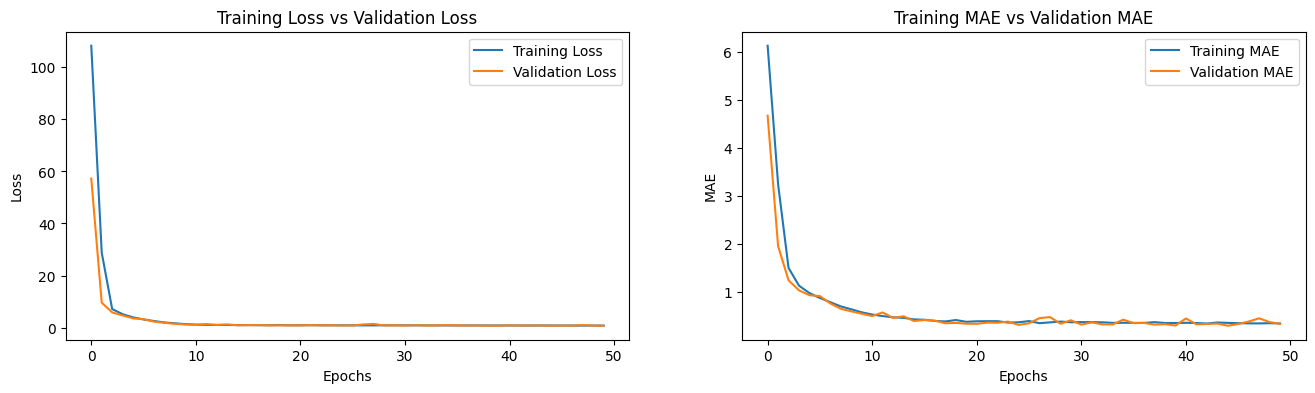

In [184]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_student_model_soft_1.history['loss'], label='Training Loss')
plt.plot(history_student_model_soft_1.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_student_model_soft_1.history['mae'], label='Training MAE')
plt.plot(history_student_model_soft_1.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

### temperature = 5

In [185]:
# Get softened outputs from the teacher model
temperature = 5
soft_targets = get_softened_outputs(teacher_model, X_train_scaled, temperature)

# Check for invalid values in soft targets
print(np.isnan(soft_targets).any(), np.isinf(soft_targets).any())

# Define the student model architecture
student_model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), name='hidden_layer_1'),
    Dense(32, activation='relu', name='hidden_layer_2'),
    Dense(1, activation='linear', name='output_layer')
])

# Compile the student model
student_model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Combining soft targets and ground truth labels
Y_train = y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

# Check for invalid values in y_combined
print(np.isnan(y_combined).any(), np.isinf(y_combined).any())
print(np.min(y_combined), np.max(y_combined))

450/450 [==============================] - 1s 2ms/step
False False
False False
0.5 46.176872582842904


In [189]:
# Train the student model using a combination of soft targets and ground truth labels
history_student_model_soft_2 = student_model_2.fit(X_train_scaled, y_combined, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
360/360 [==============================] - 2s 6ms/step - loss: 0.7658 - mae: 0.3646 - val_loss: 0.7065 - val_mae: 0.3259
Epoch 2/50
360/360 [==============================] - 2s 5ms/step - loss: 0.7332 - mae: 0.3508 - val_loss: 0.6921 - val_mae: 0.3290
Epoch 3/50
360/360 [==============================] - 2s 4ms/step - loss: 0.7497 - mae: 0.3549 - val_loss: 0.6977 - val_mae: 0.3291
Epoch 4/50
360/360 [==============================] - 1s 3ms/step - loss: 0.7859 - mae: 0.3803 - val_loss: 0.7423 - val_mae: 0.4208
Epoch 5/50
360/360 [==============================] - 1s 2ms/step - loss: 0.7551 - mae: 0.3725 - val_loss: 0.7326 - val_mae: 0.3808
Epoch 6/50
360/360 [==============================] - 1s 2ms/step - loss: 0.7398 - mae: 0.3555 - val_loss: 0.7054 - val_mae: 0.3145
Epoch 7/50
360/360 [==============================] - 1s 2ms/step - loss: 0.7301 - mae: 0.3474 - val_loss: 0.8129 - val_mae: 0.3402
Epoch 8/50
360/360 [==============================] - 1s 2ms/step - loss: 0.

In [190]:
# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_2.evaluate(X_val_scaled, y_val)
print(f"Validation Loss (Soft Distillation): {val_loss_soft:.3f}")
print(f"Validation MAE (Soft Distillation): {val_mae_soft:.3f}")

113/113 [==============================] - 0s 2ms/step - loss: 190.4353 - mae: 7.7363
Validation Loss (Soft Distillation): 190.435
Validation MAE (Soft Distillation): 7.736


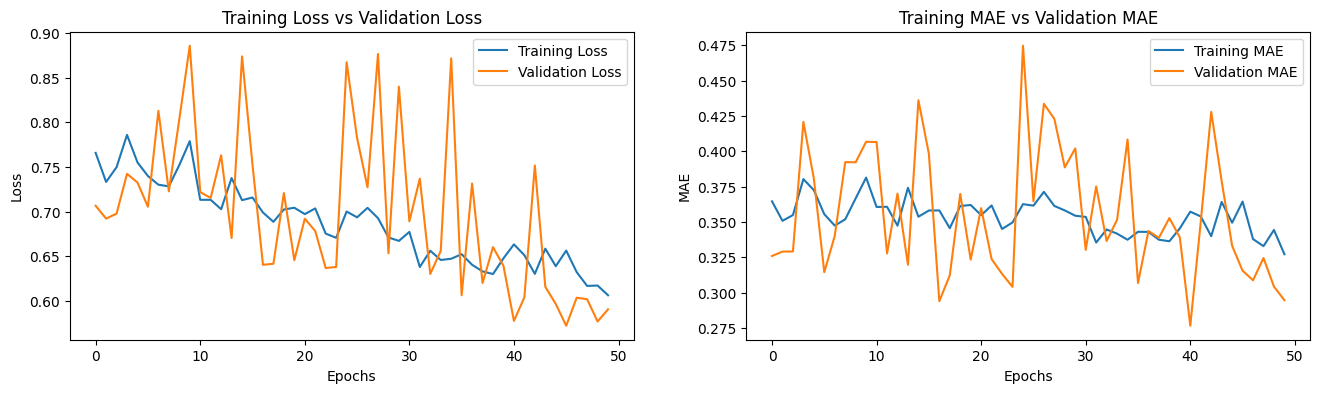

In [191]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_student_model_soft_2.history['loss'], label='Training Loss')
plt.plot(history_student_model_soft_2.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_student_model_soft_2.history['mae'], label='Training MAE')
plt.plot(history_student_model_soft_2.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

### temperature = 10

In [203]:
# Get softened outputs from the teacher model
temperature = 10
soft_targets = get_softened_outputs(teacher_model, X_train_scaled, temperature)

# Check for invalid values in soft targets
print(np.isnan(soft_targets).any(), np.isinf(soft_targets).any())

# Define the student model architecture
student_model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), name='hidden_layer_1'),
    Dense(32, activation='relu', name='hidden_layer_2'),
    Dense(1, activation='linear', name='output_layer')
])

# Compile the student model
student_model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Combining soft targets and ground truth labels
Y_train = y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

# Check for invalid values in y_combined
print(np.isnan(y_combined).any(), np.isinf(y_combined).any())
print(np.min(y_combined), np.max(y_combined))

450/450 [==============================] - 1s 1ms/step
False False
False False
0.5 46.176872582842904


In [204]:
# Train the student model using a combination of soft targets and ground truth labels
history_student_model_soft_3 = student_model_2.fit(X_train_scaled, y_combined, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
360/360 [==============================] - 53s 3ms/step - loss: 115.5504 - mae: 6.3911 - val_loss: 68.2764 - val_mae: 4.8775
Epoch 2/50
360/360 [==============================] - 1s 2ms/step - loss: 37.3982 - mae: 3.6635 - val_loss: 10.9289 - val_mae: 1.9122
Epoch 3/50
360/360 [==============================] - 1s 2ms/step - loss: 6.6191 - mae: 1.4070 - val_loss: 4.7973 - val_mae: 1.1225
Epoch 4/50
360/360 [==============================] - 1s 2ms/step - loss: 4.3316 - mae: 1.0544 - val_loss: 4.2392 - val_mae: 1.0884
Epoch 5/50
360/360 [==============================] - 1s 2ms/step - loss: 3.7277 - mae: 0.9812 - val_loss: 3.6053 - val_mae: 0.9669
Epoch 6/50
360/360 [==============================] - 1s 2ms/step - loss: 3.2188 - mae: 0.9251 - val_loss: 3.4775 - val_mae: 0.9765
Epoch 7/50
360/360 [==============================] - 1s 2ms/step - loss: 2.8292 - mae: 0.8826 - val_loss: 2.8211 - val_mae: 0.8800
Epoch 8/50
360/360 [==============================] - 1s 2ms/step - lo

In [205]:
# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_2.evaluate(X_val_scaled, y_val)
print(f"Validation Loss (Soft Distillation): {val_loss_soft:.3f}")
print(f"Validation MAE (Soft Distillation): {val_mae_soft:.3f}")

113/113 [==============================] - 1s 3ms/step - loss: 195.3684 - mae: 7.7142
Validation Loss (Soft Distillation): 195.368
Validation MAE (Soft Distillation): 7.714


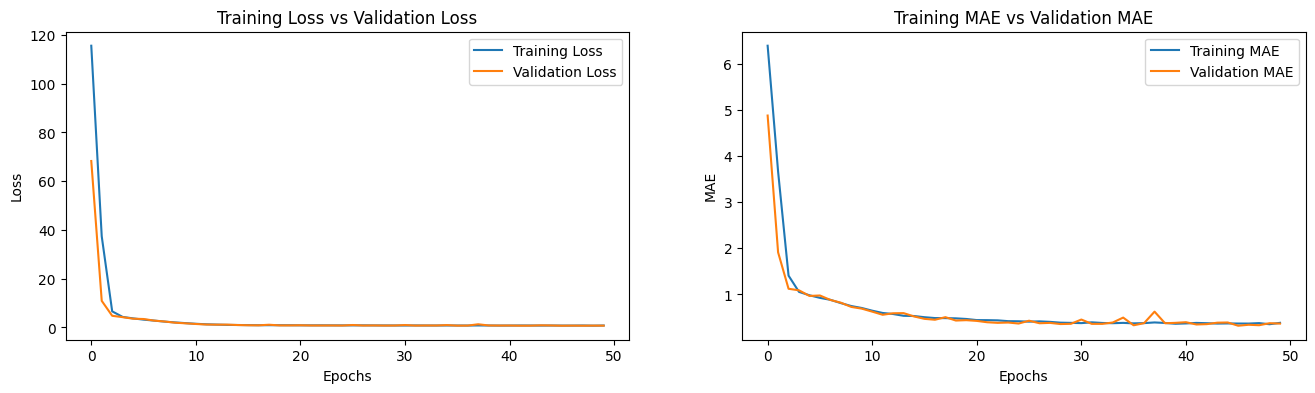

In [206]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_student_model_soft_3.history['loss'], label='Training Loss')
plt.plot(history_student_model_soft_3.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_student_model_soft_3.history['mae'], label='Training MAE')
plt.plot(history_student_model_soft_3.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

## Time Comparison

In [199]:
# Timing and memory usage measurement function
def measure_training_time_memory(model, X, y, epochs=50):
    start_time = time.time()
    mem_usage = memory_usage((model.fit, (X, y), {'epochs': epochs, 'batch_size': 32, 'validation_split': 0.2, 'callbacks': [tf.keras.callbacks.EarlyStopping(patience=5)]}), interval=0.1)
    end_time = time.time()
    training_time = end_time - start_time
    max_memory = max(mem_usage)
    return training_time, max_memory

In [200]:
# Prepare soft targets for soft distillation
temperature = 5  # taken on the basis of above evualation
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)
Y_train = y_train.reshape(-1, 1)

# Prepare combined targets for soft distillation
y_combined = 0.5 * Y_train + 0.5 * soft_targets

# Measure performance of the teacher model
print("Teacher Model Performance:")
teacher_time, teacher_memory = measure_training_time_memory(teacher_model, X_train_scaled, Y_train)

# Measure performance of the student model (hard distillation)
print("Student Model Performance Using Hard Distillation:")
student_hard_time, student_hard_memory = measure_training_time_memory(student_model_1, X_train_scaled, y_train)

# Measure performance of the student model (soft distillation)
print("Student Model Performance Using Soft Distillation:")
student_soft_time, student_soft_memory = measure_training_time_memory(student_model_2, X_train_scaled, y_combined)

450/450 [==============================] - 1s 2ms/step
Teacher Model Performance:


<ipython-input-180-d8639feade63>:4: RuntimeWarning: overflow encountered in exp
  exp_logits = np.exp(logits)
<ipython-input-180-d8639feade63>:5: RuntimeWarning: invalid value encountered in divide
  return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)


Epoch 1/50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


360/360 [==============================] - 2s 4ms/step - loss: 2.6750 - mae: 0.6314 - val_loss: 2.5650 - val_mae: 0.6080
Epoch 2/50
360/360 [==============================] - 1s 3ms/step - loss: 2.6160 - mae: 0.6294 - val_loss: 2.3779 - val_mae: 0.6257
Epoch 3/50
360/360 [==============================] - 1s 3ms/step - loss: 2.6190 - mae: 0.6195 - val_loss: 2.9619 - val_mae: 0.6252
Epoch 4/50
360/360 [==============================] - 1s 2ms/step - loss: 2.7173 - mae: 0.6483 - val_loss: 2.3604 - val_mae: 0.5733
Epoch 5/50
360/360 [==============================] - 1s 3ms/step - loss: 2.6479 - mae: 0.6212 - val_loss: 2.4248 - val_mae: 0.5707
Epoch 6/50
360/360 [==============================] - 1s 3ms/step - loss: 2.5107 - mae: 0.5925 - val_loss: 2.1969 - val_mae: 0.5432
Epoch 7/50
360/360 [==============================] - 1s 2ms/step - loss: 2.5410 - mae: 0.5959 - val_loss: 2.1834 - val_mae: 0.5478
Epoch 8/50
360/360 [==============================] - 1s 2ms/step - loss: 2.6297 - mae:

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Student Model Performance Using Hard Distillation:
Epoch 1/50
360/360 [==============================] - 1s 3ms/step - loss: 3.0130 - mae: 0.7229 - val_loss: 2.9260 - val_mae: 0.6826
Epoch 2/50
360/360 [==============================] - 1s 2ms/step - loss: 3.0323 - mae: 0.7224 - val_loss: 2.8735 - val_mae: 0.6884
Epoch 3/50
360/360 [==============================] - 1s 2ms/step - loss: 3.0518 - mae: 0.7247 - val_loss: 2.8585 - val_mae: 0.6631
Epoch 4/50
360/360 [==============================] - 1s 2ms/step - loss: 3.0069 - mae: 0.7119 - val_loss: 2.8719 - val_mae: 0.6785
Epoch 5/50
360/360 [==============================] - 1s 2ms/step - loss: 2.9827 - mae: 0.7190 - val_loss: 3.5416 - val_mae: 0.8131
Epoch 6/50
360/360 [==============================] - 1s 2ms/step - loss: 2.9583 - mae: 0.7196 - val_loss: 2.9418 - val_mae: 0.6647
Epoch 7/50
360/360 [==============================] - 1s 2ms/step - loss: 2.9890 - mae: 0.7247 - val_loss: 3.1256 - val_mae: 0.7957
Epoch 8/50
360/360 [=====

In [201]:
print(f"Teacher Model - Training Time: {teacher_time:.4f} seconds, Memory Usage: {teacher_memory:.4f} MiB")
print(f"Student Model (Hard Distillation) - Training Time: {student_hard_time:.4f} seconds, Memory Usage: {student_hard_memory:.4f} MiB")
print(f"Student Model (Soft Distillation) - Training Time: {student_soft_time:.4f} seconds, Memory Usage: {student_soft_memory:.4f} MiB")

Teacher Model - Training Time: 14.4286 seconds, Memory Usage: 986.0586 MiB
Student Model (Hard Distillation) - Training Time: 30.0792 seconds, Memory Usage: 986.8203 MiB
Student Model (Soft Distillation) - Training Time: 4.4004 seconds, Memory Usage: 987.2227 MiB


# Knowledge Distillation for USA dataset

## Importing the dataset

In [207]:
usa_data = pd.read_excel("drive/MyDrive/datasets_ont_lab/DataSet_USA_3k_5k.xlsx")

## Data preprocessing

We will be using `GSNR_24` as our target variable.

In [287]:
# Define the attribute columns and the target variable
attribute_columns = [f'Power_{i}' for i in range(1, 77)] + \
                    [f'ASE_{i}' for i in range(1, 77)] + \
                    [f'NLI_{i}' for i in range(1, 77)] + \
                    ['No. Spans'] + \
                    ['Total Distance(m)']

# Label
target_column = 'GSNR_24'

In [305]:
# Display the first few rows of the dataset
usa_data.head()

,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,Power_9,Power_10,...,GSNR_72,GSNR_73,GSNR_74,GSNR_75,GSNR_76,Source,Destination,No. Spans,Total Distance(m),Number of ON channels
0,0.000000,0.000000,0.000096,0.000096,0.000096,0.000000,0.000096,0.0,0.000096,0.0,...,0.000000,0.000000,26.391513,0.000000,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26
1,0.000000,0.000096,0.000000,0.000096,0.000000,0.000096,0.000000,0.0,0.000000,0.0,...,0.000000,25.764675,0.000000,0.000000,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26
2,0.000000,0.000000,0.000000,0.000096,0.000000,0.000000,0.000000,0.0,0.000096,0.0,...,0.000000,0.000000,0.000000,24.616361,24.297057,trxHouston0,trxJacksonville58,23,2050305.0,26
3,0.000096,0.000096,0.000095,0.000095,0.000096,0.000000,0.000000,0.0,0.000096,0.0,...,22.810189,0.000000,0.000000,0.000000,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26
4,0.000000,0.000000,0.000096,0.000000,0.000096,0.000000,0.000000,0.0,0.000096,0.0,...,21.211149,21.131602,21.349516,22.572032,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26


In [307]:
# Checking data types of columns
usa_data.dtypes

Power_1                  float64
Power_2                  float64
Power_3                  float64
Power_4                  float64
Power_5                  float64
                          ...   
Source                    object
Destination               object
No. Spans                  int64
Total Distance(m)        float64
Number of ON channels      int64
Length: 537, dtype: object

In [308]:
# Summary statistics
usa_data.describe()

,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,Power_9,Power_10,...,GSNR_70,GSNR_71,GSNR_72,GSNR_73,GSNR_74,GSNR_75,GSNR_76,No. Spans,Total Distance(m),Number of ON channels
count,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,...,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,3.600000e+04,36000.000000
mean,0.000036,0.000035,0.000035,0.000035,0.000035,0.000035,0.000036,0.000035,0.000035,0.000034,...,70.334077,69.503057,69.144815,68.683463,70.419932,69.120334,72.560639,25.000000,2.239592e+06,33.680000
std,0.000046,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,...,301.964415,300.274256,299.556869,298.749498,302.202482,299.562948,306.652302,16.314842,1.487331e+06,4.345663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.421400e+04,26.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,9.325925e+05,30.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.500000,2.126529e+06,34.000000
75%,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,...,17.575675,17.546693,17.551754,17.577307,17.913576,17.951067,18.800776,33.500000,2.994246e+06,37.000000
max,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,1724.812781,1701.651596,1714.612288,1720.937498,1708.909051,1698.616350,1719.680238,57.000000,5.166188e+06,41.000000


In [309]:
# Check for missing values
usa_data.isnull().sum()

Power_1                  0
Power_2                  0
Power_3                  0
Power_4                  0
Power_5                  0
                        ..
Source                   0
Destination              0
No. Spans                0
Total Distance(m)        0
Number of ON channels    0
Length: 537, dtype: int64

## Applying feature scaling

In [312]:
sc = StandardScaler()

X = sc.fit_transform(usa_data[attribute_columns])
X = pd.DataFrame(X, columns=attribute_columns)

y = sc.fit_transform(usa_data[target_column].values.reshape(-1, 1))
y = pd.DataFrame(y, columns=[target_column])

In [313]:
print(f'X size = {X.shape}\ny size = {y.shape}')

X size = (36000, 230)
y size = (36000, 1)


## Splitting dataset into training set and validation set

In [314]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [315]:
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")

Training set shape: (28800, 230), (28800, 1)
Validation set shape: (7200, 230), (7200, 1)


## Building and training teacher model

In [316]:
# Define a large teacher model architecture
teacher_model_2 = Sequential([
    Dense(256, activation='relu', input_shape=(len(attribute_columns),)),  # First layer with 256 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(128, activation='relu'),  # Second layer with 128 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(64, activation='relu'),  # Third layer with 64 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(32, activation='relu'),  # Fourth layer with 32 neurons
    Dense(16, activation='relu'),  # Fifth layer with 16 neurons
    Dense(1)  # Output layer for regression task
])

In [317]:
# Compile the model
teacher_model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [318]:
# Train the model
history_teacher_model_2 = teacher_model_2.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2)

Epoch 1/25
360/360 [==============================] - 3s 6ms/step - loss: 0.7956 - mae: 0.3429 - val_loss: 0.7807 - val_mae: 0.3322
Epoch 2/25
360/360 [==============================] - 2s 5ms/step - loss: 0.7871 - mae: 0.3184 - val_loss: 0.8110 - val_mae: 0.3005
Epoch 3/25
360/360 [==============================] - 2s 5ms/step - loss: 0.7752 - mae: 0.3153 - val_loss: 0.7744 - val_mae: 0.3139
Epoch 4/25
360/360 [==============================] - 3s 8ms/step - loss: 0.7685 - mae: 0.3110 - val_loss: 0.7474 - val_mae: 0.3163
Epoch 5/25
360/360 [==============================] - 2s 7ms/step - loss: 0.7524 - mae: 0.3031 - val_loss: 0.7199 - val_mae: 0.3083
Epoch 6/25
360/360 [==============================] - 3s 9ms/step - loss: 0.7328 - mae: 0.2911 - val_loss: 0.7101 - val_mae: 0.2804
Epoch 7/25
360/360 [==============================] - 4s 11ms/step - loss: 0.6926 - mae: 0.2757 - val_loss: 0.6592 - val_mae: 0.2811
Epoch 8/25
360/360 [==============================] - 4s 11ms/step - loss: 

In [320]:
# Evaluate the model on the validation set
val_loss, val_mae = teacher_model_2.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss:.3f}')
print(f'Validation MAE: {val_mae:.3f}')

225/225 [==============================] - 1s 3ms/step - loss: 0.8016 - mae: 0.3089
Validation Loss: 0.802
Validation MAE: 0.309


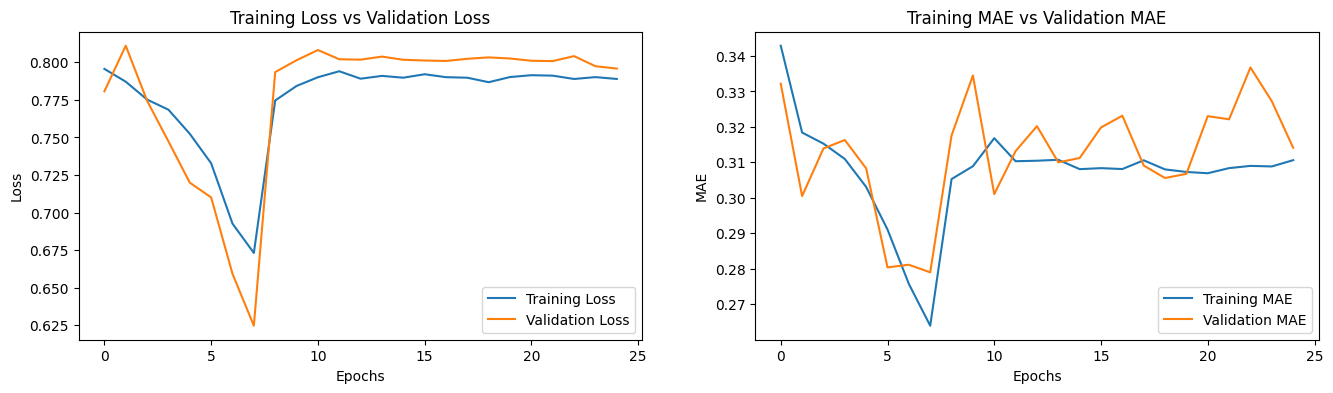

In [322]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_teacher_model_2.history['loss'], label='Training Loss')
plt.plot(history_teacher_model_2.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_teacher_model_2.history['mae'], label='Training MAE')
plt.plot(history_teacher_model_2.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

## Knowledge Distillation - Hard

In [323]:
# Define the student model architecture
student_model_hard = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

In [324]:
# Compile the student model
student_model_hard.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [328]:
# Train the student model
history_hard = student_model_hard.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2)

Epoch 1/25
360/360 [==============================] - 2s 5ms/step - loss: 0.6551 - mae: 0.2687 - val_loss: 0.6490 - val_mae: 0.2591
Epoch 2/25
360/360 [==============================] - 1s 4ms/step - loss: 0.6752 - mae: 0.2694 - val_loss: 0.6261 - val_mae: 0.2675
Epoch 3/25
360/360 [==============================] - 1s 3ms/step - loss: 0.6724 - mae: 0.2695 - val_loss: 0.6317 - val_mae: 0.2629
Epoch 4/25
360/360 [==============================] - 1s 3ms/step - loss: 0.6789 - mae: 0.2718 - val_loss: 0.6211 - val_mae: 0.2650
Epoch 5/25
360/360 [==============================] - 1s 3ms/step - loss: 0.6748 - mae: 0.2729 - val_loss: 0.6306 - val_mae: 0.2635
Epoch 6/25
360/360 [==============================] - 1s 3ms/step - loss: 0.6725 - mae: 0.2703 - val_loss: 0.6144 - val_mae: 0.2706
Epoch 7/25
360/360 [==============================] - 1s 3ms/step - loss: 0.6730 - mae: 0.2687 - val_loss: 0.6581 - val_mae: 0.2603
Epoch 8/25
360/360 [==============================] - 1s 3ms/step - loss: 0.

In [329]:
# Evaluate the student model on the validation set
student_val_loss, student_val_mae = student_model_hard.evaluate(X_val_scaled, y_val)
print(f'Student Model Validation Loss: {student_val_loss:.3f}')
print(f'Student Model Validation MAE: {student_val_mae:.3f}')

225/225 [==============================] - 1s 2ms/step - loss: 0.5982 - mae: 0.2565
Student Model Validation Loss: 0.598
Student Model Validation MAE: 0.257


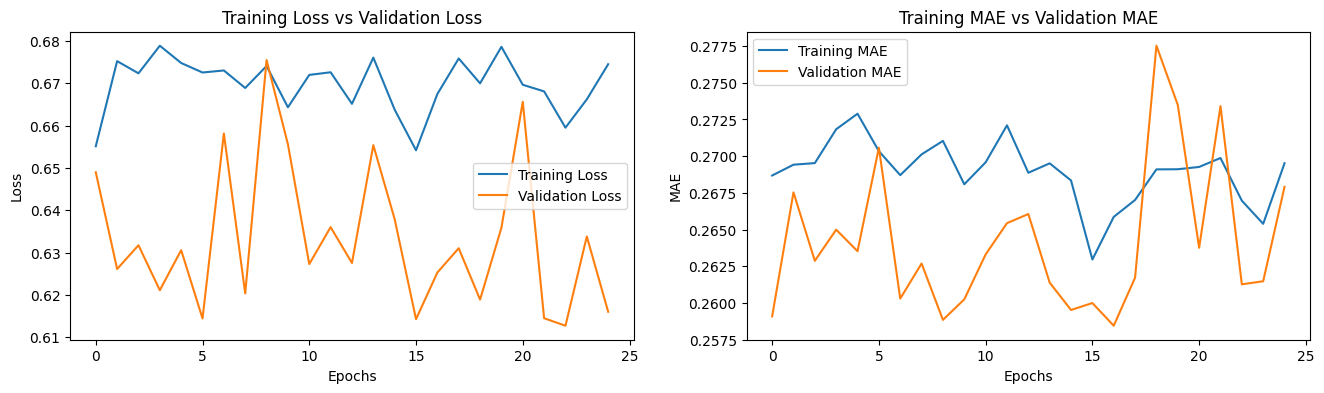

In [331]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_hard.history['loss'], label='Training Loss')
plt.plot(history_hard.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_hard.history['mae'], label='Training MAE')
plt.plot(history_hard.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

## Knowledge Distillation - Soft

In [332]:
def get_softened_outputs(model, data, temperature=1):
    logits = model.predict(data) / temperature
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

### temperature = 1

In [335]:
# Get softened outputs from the teacher model
temperature = 1
soft_targets = get_softened_outputs(teacher_model_2, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = y_train.values.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)

900/900 [==============================] - 2s 3ms/step
Epoch 1/25
360/360 [==============================] - 4s 7ms/step - loss: 0.2615 - mae: 0.2871 - val_loss: 0.2190 - val_mae: 0.1734
Epoch 2/25
360/360 [==============================] - 2s 5ms/step - loss: 0.2002 - mae: 0.1994 - val_loss: 0.2163 - val_mae: 0.1563
Epoch 3/25
360/360 [==============================] - 2s 6ms/step - loss: 0.1990 - mae: 0.1812 - val_loss: 0.1903 - val_mae: 0.1788
Epoch 4/25
360/360 [==============================] - 4s 11ms/step - loss: 0.1963 - mae: 0.1723 - val_loss: 0.1887 - val_mae: 0.1589
Epoch 5/25
360/360 [==============================] - 1s 3ms/step - loss: 0.1893 - mae: 0.1633 - val_loss: 0.1984 - val_mae: 0.1360
Epoch 6/25
360/360 [==============================] - 1s 3ms/step - loss: 0.1882 - mae: 0.1571 - val_loss: 0.1868 - val_mae: 0.1402
Epoch 7/25
360/360 [==============================] - 1s 3ms/step - loss: 0.1809 - mae: 0.1512 - val_loss: 0.1826 - val_mae: 0.1749
Epoch 8/25
360/360 [

In [336]:
# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_val, y_val)
print(f'Validation Loss (Soft Distillation): {val_loss_soft:.3f}')
print(f"Validation MAE (Soft Distillation): {val_mae_soft:.3f}")

225/225 [==============================] - 0s 2ms/step - loss: 1.0577 - mae: 0.7785
Validation Loss (Soft Distillation): 1.058
Validation MAE (Soft Distillation): 0.778


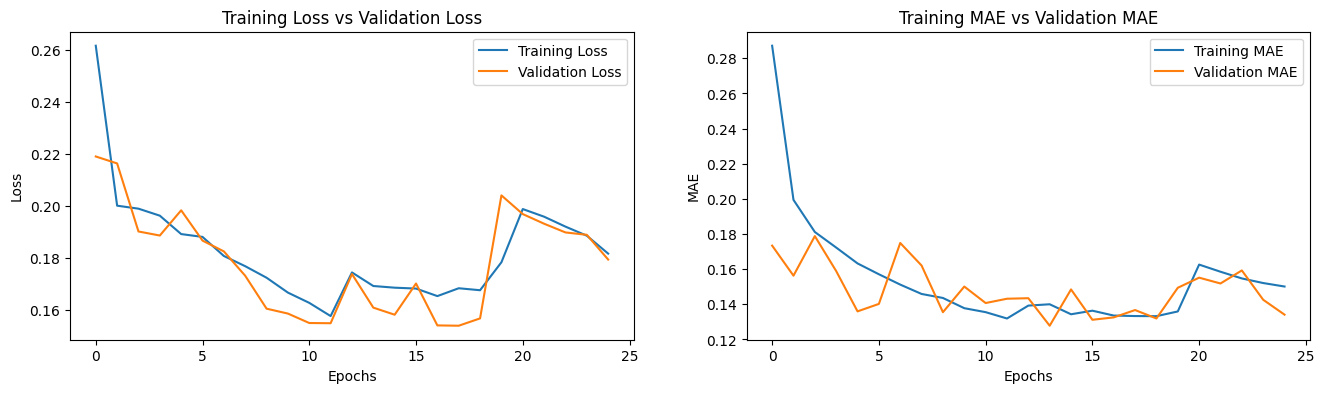

In [337]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_soft.history['loss'], label='Training Loss')
plt.plot(history_soft.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_soft.history['mae'], label='Training MAE')
plt.plot(history_soft.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

### temperature = 5

In [338]:
# Get softened outputs from the teacher model
temperature = 5
soft_targets = get_softened_outputs(teacher_model_2, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)

900/900 [==============================] - 3s 3ms/step
Epoch 1/25
360/360 [==============================] - 2s 3ms/step - loss: 0.3382 - mae: 0.3635 - val_loss: 0.2020 - val_mae: 0.2035
Epoch 2/25
360/360 [==============================] - 1s 3ms/step - loss: 0.2106 - mae: 0.2218 - val_loss: 0.1951 - val_mae: 0.1856
Epoch 3/25
360/360 [==============================] - 2s 4ms/step - loss: 0.2013 - mae: 0.1965 - val_loss: 0.1933 - val_mae: 0.1762
Epoch 4/25
360/360 [==============================] - 3s 8ms/step - loss: 0.1950 - mae: 0.1846 - val_loss: 0.1947 - val_mae: 0.1638
Epoch 5/25
360/360 [==============================] - 3s 9ms/step - loss: 0.1949 - mae: 0.1743 - val_loss: 0.1905 - val_mae: 0.1738
Epoch 6/25
360/360 [==============================] - 2s 5ms/step - loss: 0.1941 - mae: 0.1680 - val_loss: 0.1909 - val_mae: 0.1559
Epoch 7/25
360/360 [==============================] - 1s 3ms/step - loss: 0.1919 - mae: 0.1617 - val_loss: 0.1927 - val_mae: 0.1791
Epoch 8/25
360/360 [=

In [339]:
# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_val, y_val)
print(f'Validation Loss (Soft Distillation): {val_loss_soft:.3f}')
print(f"Validation MAE (Soft Distillation): {val_mae_soft:.3f}")

225/225 [==============================] - 0s 1ms/step - loss: 0.9879 - mae: 0.7669
Validation Loss (Soft Distillation): 0.988
Validation MAE (Soft Distillation): 0.767


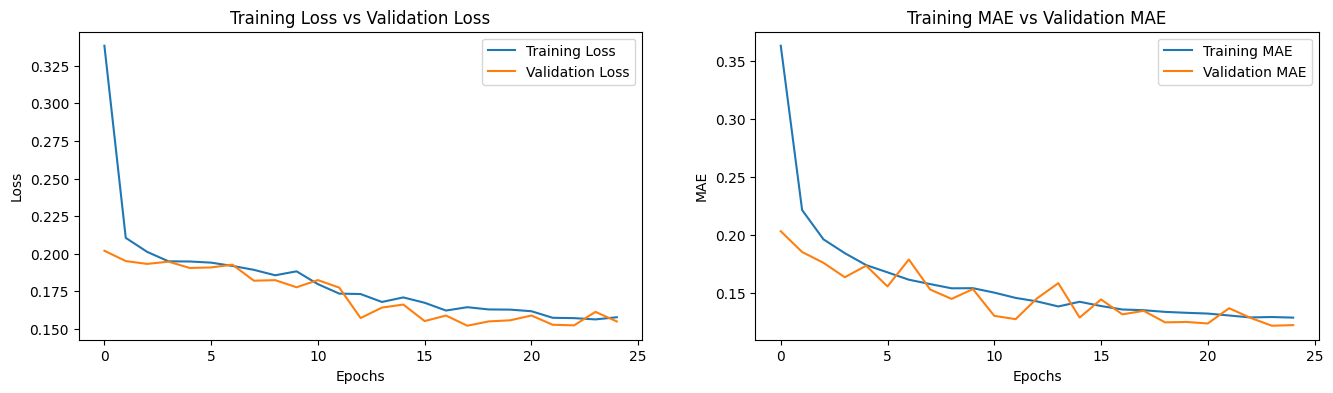

In [340]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_soft.history['loss'], label='Training Loss')
plt.plot(history_soft.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_soft.history['mae'], label='Training MAE')
plt.plot(history_soft.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

### temperature = 10

In [341]:
# Get softened outputs from the teacher model
temperature = 10
soft_targets = get_softened_outputs(teacher_model_2, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)

900/900 [==============================] - 3s 3ms/step
Epoch 1/25
360/360 [==============================] - 2s 3ms/step - loss: 0.3314 - mae: 0.3626 - val_loss: 0.2028 - val_mae: 0.2228
Epoch 2/25
360/360 [==============================] - 1s 2ms/step - loss: 0.2096 - mae: 0.2220 - val_loss: 0.1959 - val_mae: 0.1800
Epoch 3/25
360/360 [==============================] - 1s 4ms/step - loss: 0.1997 - mae: 0.1922 - val_loss: 0.1917 - val_mae: 0.1757
Epoch 4/25
360/360 [==============================] - 1s 4ms/step - loss: 0.1958 - mae: 0.1789 - val_loss: 0.1897 - val_mae: 0.1630
Epoch 5/25
360/360 [==============================] - 2s 4ms/step - loss: 0.1946 - mae: 0.1692 - val_loss: 0.1898 - val_mae: 0.1603
Epoch 6/25
360/360 [==============================] - 1s 4ms/step - loss: 0.1899 - mae: 0.1630 - val_loss: 0.1889 - val_mae: 0.1482
Epoch 7/25
360/360 [==============================] - 2s 5ms/step - loss: 0.1866 - mae: 0.1577 - val_loss: 0.1951 - val_mae: 0.1377
Epoch 8/25
360/360 [=

In [342]:
# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_val, y_val)
print(f'Validation Loss (Soft Distillation): {val_loss_soft:.3f}')
print(f"Validation MAE (Soft Distillation): {val_mae_soft:.3f}")

225/225 [==============================] - 1s 3ms/step - loss: 1.0521 - mae: 0.7719
Validation Loss (Soft Distillation): 1.052
Validation MAE (Soft Distillation): 0.772


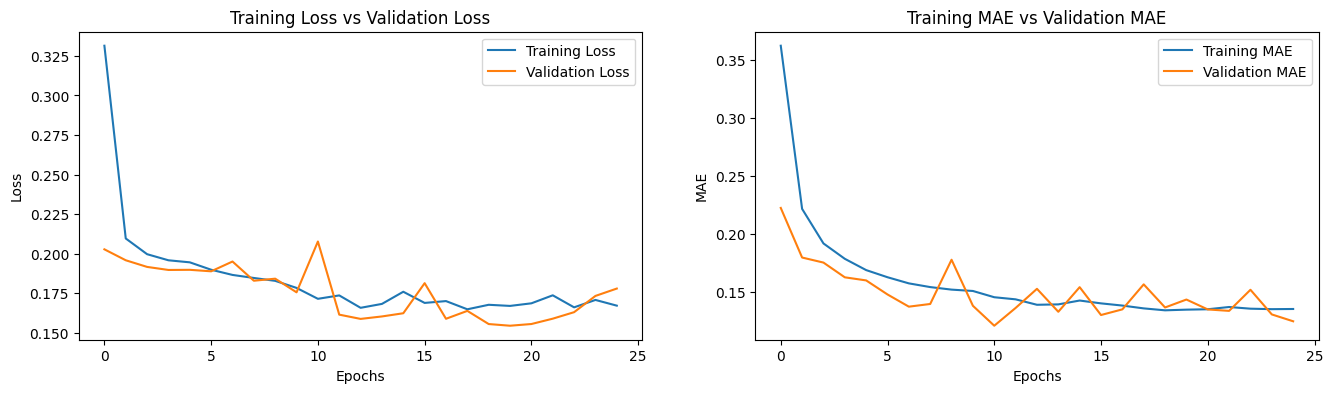

In [343]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_soft.history['loss'], label='Training Loss')
plt.plot(history_soft.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_soft.history['mae'], label='Training MAE')
plt.plot(history_soft.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

## Time Comparison

In [344]:
# Prepare soft targets for soft distillation
temperature = 5  # taken on the basis of above evualation
soft_targets = get_softened_outputs(teacher_model_2, X_train, temperature)

# Prepare combined targets for soft distillation
y_combined = 0.5 * Y_train + 0.5 * soft_targets

# Measure performance of the teacher model
print("Teacher Model Performance:")
teacher_time, teacher_memory = measure_training_time_memory(teacher_model_2, X_train, y_train)

# Measure performance of the student model (hard distillation)
print("Student Model Performance Using Hard Distillation:")
student_hard_time, student_hard_memory = measure_training_time_memory(student_model_hard, X_train, y_train)

# Measure performance of the student model (soft distillation)
print("Student Model Performance Using Soft Distillation:")
student_soft_time, student_soft_memory = measure_training_time_memory(student_model_soft, X_train, y_combined)

900/900 [==============================] - 2s 3ms/step
Teacher Model Performance:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
720/720 [==============================] - 5s 5ms/step - loss: 0.7837 - mae: 0.3096 - val_loss: 0.7837 - val_mae: 0.3148
Epoch 2/50
720/720 [==============================] - 3s 4ms/step - loss: 0.7729 - mae: 0.3074 - val_loss: 0.7913 - val_mae: 0.2915
Epoch 3/50
720/720 [==============================] - 3s 4ms/step - loss: 0.7359 - mae: 0.2994 - val_loss: 0.7038 - val_mae: 0.2620
Epoch 4/50
720/720 [==============================] - 4s 6ms/step - loss: 0.7662 - mae: 0.3002 - val_loss: 0.8105 - val_mae: 0.2925
Epoch 5/50
720/720 [==============================] - 4s 6ms/step - loss: 0.7919 - mae: 0.3066 - val_loss: 0.8006 - val_mae: 0.3193
Epoch 6/50
720/720 [==============================] - 3s 4ms/step - loss: 0.7901 - mae: 0.3080 - val_loss: 0.8021 - val_mae: 0.3037
Epoch 7/50
720/720 [==============================] - 3s 4ms/step - loss: 0.7908 - mae: 0.3076 - val_loss: 0.8014 - val_mae: 0.3127
Epoch 8/50
720/720 [==============================] - 4s 5ms/step - loss: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
720/720 [==============================] - 4s 5ms/step - loss: 0.6777 - mae: 0.2724 - val_loss: 0.6415 - val_mae: 0.2590
Epoch 2/50
720/720 [==============================] - 2s 3ms/step - loss: 0.6656 - mae: 0.2688 - val_loss: 0.6155 - val_mae: 0.2608
Epoch 3/50
720/720 [==============================] - 2s 2ms/step - loss: 0.6840 - mae: 0.2746 - val_loss: 0.6371 - val_mae: 0.2588
Epoch 4/50
720/720 [==============================] - 2s 2ms/step - loss: 0.6722 - mae: 0.2707 - val_loss: 0.6265 - val_mae: 0.2682
Epoch 5/50
720/720 [==============================] - 2s 3ms/step - loss: 0.6734 - mae: 0.2693 - val_loss: 0.6163 - val_mae: 0.2698
Epoch 6/50
720/720 [==============================] - 2s 3ms/step - loss: 0.6604 - mae: 0.2697 - val_loss: 0.6390 - val_mae: 0.2561
Epoch 7/50
720/720 [==============================] - 3s 4ms/step - loss: 0.6518 - mae: 0.2638 - val_loss: 0.6132 - val_mae: 0.2611
Epoch 8/50
720/720 [==============================] - 3s 4ms/step - loss: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
720/720 [==============================] - 3s 3ms/step - loss: 0.1687 - mae: 0.1352 - val_loss: 0.1550 - val_mae: 0.1427
Epoch 2/50
720/720 [==============================] - 3s 4ms/step - loss: 0.1706 - mae: 0.1371 - val_loss: 0.1553 - val_mae: 0.1336
Epoch 3/50
720/720 [==============================] - 2s 3ms/step - loss: 0.1662 - mae: 0.1339 - val_loss: 0.1565 - val_mae: 0.1331
Epoch 4/50
720/720 [==============================] - 2s 2ms/step - loss: 0.1714 - mae: 0.1356 - val_loss: 0.1688 - val_mae: 0.1261
Epoch 5/50
720/720 [==============================] - 2s 3ms/step - loss: 0.1722 - mae: 0.1366 - val_loss: 0.1621 - val_mae: 0.1304
Epoch 6/50
720/720 [==============================] - 2s 3ms/step - loss: 0.1690 - mae: 0.1343 - val_loss: 0.1547 - val_mae: 0.1316
Epoch 7/50
720/720 [==============================] - 2s 3ms/step - loss: 0.1662 - mae: 0.1320 - val_loss: 0.1544 - val_mae: 0.1301
Epoch 8/50
720/720 [==============================] - 2s 3ms/step - loss: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [345]:
print(f"Teacher Model - Training Time: {teacher_time:.4f} seconds, Memory Usage: {teacher_memory:.4f} MiB")
print(f"Student Model (Hard Distillation) - Training Time: {student_hard_time:.4f} seconds, Memory Usage: {student_hard_memory:.4f} MiB")
print(f"Student Model (Soft Distillation) - Training Time: {student_soft_time:.4f} seconds, Memory Usage: {student_soft_memory:.4f} MiB")

Teacher Model - Training Time: 30.3243 seconds, Memory Usage: 2437.9922 MiB
Student Model (Hard Distillation) - Training Time: 26.4381 seconds, Memory Usage: 2461.3125 MiB
Student Model (Soft Distillation) - Training Time: 26.7504 seconds, Memory Usage: 2501.7500 MiB
